In [1]:
import pandas as pd
import os
from os.path import join
import seaborn as sns
import numpy as np
from coevolve import read_msa
from coevolve.visualization.fig_utils import *
from collections import defaultdict
import matplotlib

/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Project Directory: /data2/isshamie/coevolve

Config paths:
__name__ coevolve.config
__package__ coevolve
__file__ /data2/isshamie/coevolve/coevolve/config.py
__cached__ /data2/isshamie/coevolve/coevolve/__pycache__/config.cpython-37.pyc
path /data2/isshamie/coevolve/coevolve/config.py
DATA_DIR /data2/isshamie/coevolve/data
RESULTS /data2/isshamie/coevolve/data/processed
FIGURES_DIR /data2/isshamie/coevolve/figures
FIG_NET_DIR /data2/isshamie/coevolve/figures/networks
PIPELINE_F /data2/isshamie/coevolve/reports/pipeline/Pipeline.xlsx
DATA_FIG_DIR /data2/isshamie/coevolve/data/processed/figures
PARAMS_DIR /data2/isshamie/coevolve/params
TEST_DIR /data2/isshamie/coevolve/tests
ORTHO_FIGURES_DIR /data2/isshamie/coevolve/figures/orthologs
ORTHO_SEQS_DIR /data2/isshamie/coevolve/data/external/orthodb/protein_sequences/
ODB_DIR /data2/isshamie/coevolve/data/external/orthodb/
TAXA_ID_TO_NAME_RAW /data2/isshamie/coevolve/data/external/ncbi_taxonomy/names.dmp
NCBI_FOLDER /data2/isshamie/coevolve

## Load env variable

In [2]:
from config import RESULTS, FIGURES_DIR, PAIR_COUPLINGS_FIGURES_DIR, GLYCO_PAIR_COUPLINGS_FIGURES_DIR
print(RESULTS)
print(FIGURES_DIR)

Project Directory: /data2/isshamie/covid/covid_03302020

Config paths:
__name__ config
__package__ 
__file__ /data2/isshamie/covid/covid_03302020/notebook/config.py
__cached__ /data2/isshamie/covid/covid_03302020/notebook/__pycache__/config.cpython-37.pyc
path /data2/isshamie/covid/covid_03302020/notebook/config.py
DATA_DIR /data2/isshamie/covid/covid_03302020/data
RESULTS /data2/isshamie/covid/covid_03302020/data/processed
FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures
CONTACT_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/contact
PAIR_COUPLINGS_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/pair_couplings
GLYCO_PAIR_COUPLINGS_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/glycosites_pair_couplings
PARAMS_DIR /data2/isshamie/covid/covid_03302020/parameters
d /data2/isshamie/covid/covid_03302020/figures/glycosites_pair_couplings
UNIPROT_MAP /data2/isshamie/covid/covid_03302020/data/external/biomart/mart_export_uniprot.txt
GENE_MAP /data2/isshamie

In [3]:
evc_dir = join(RESULTS,"evc")
name = "col75_redund0.99"
evc_out = join(evc_dir,name)
align_dir = join(evc_out,"align")
coupling_dir = join(evc_out,"coupling")
 

align_prefix = os.path.join(evc_dir,name,"align",name)
coupling_prefix = os.path.join(evc_dir, name,"couplings",name)

fig_dir = join(FIGURES_DIR, "conservation")
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

    
print(coupling_prefix)
print(align_prefix)

/data2/isshamie/covid/covid_03302020/data/processed/evc/col75_redund0.99/couplings/col75_redund0.99
/data2/isshamie/covid/covid_03302020/data/processed/evc/col75_redund0.99/align/col75_redund0.99


------

## Part 1: Alignment statistics

For the monomer pipeline, the alignment is found in the align subdirectory of the output folder. For the complexes pipeline, the concatenated alignment is found in the concatenate subdirectory, and the individual monomer alignments are found in the align_1 and align_2 subdirectories. 

### Final alignment file (.a2m)

The final alignment file in [.a2m format](https://compbio.soe.ucsc.edu/a2m-desc.html). This file is used to calculate evolutionary couplings (ECs). Lowercase columns indicate columns with too many gaps that did not meet the minimum column coverage threshold, which means they were excluded from the EC calculation. Lowercase columns have a '.' for gap character by convention. Additionally, sequences which did not fulfill the the minimum sequence coverage threshold (i.e. fragments with too many gaps) have been removed from this alignment. 

*output key: alignment_file*

In [4]:
from evcouplings.align import Alignment

# Load the alignment - format will be detected automatically but can also be set manually
with open(align_prefix +  ".a2m") as f:
    aln = Alignment.from_file(f)

print("Alignment has {} sequences and {} columns".format(aln.N, aln.L))

Alignment has 2469 sequences and 1273 columns


### Alignment and EC statistics summary (_job_statistics_summary.csv)

Contains information on properties of the final alignment. This file is only produced if the *evcouplings* application is run (otherwise see alignment_statistics.csv for a truncated version of this file, *output key: statistics_file*).

Columns:
   - prefix: run prefix
   - minimum_column_coverage: user input, fraction of non-gap characters required per column
   - num_seqs: number of sequences in final alignment
   - seqlen: length of target sequence (interchangeably called the query sequence)
   - num_cov: number of uppercase columns in final alignment (columns that satisfied minimumum_column_coverage) 
   - num_lc: number of lowercase columns in final alignment (columns that did not satisfy minimum_column_coverage)
   - perc_cov: fraction of columns that are uppercase (num_cov / seqlen)
   - 1st_uc: index of first uppercase column, numbered according to target sequence
   - last_uc: index of last uppercase column, numbered according to target sequence
   - len_cov: last_uc - 1st_uc
   - num_lc_cov: number of lowercase columns between 1st_uc and last_uc (i.e. num_cov = len_cov - num_lc_cov)
   - N_eff: effective number of non-redundant sequences after clustering based on theta parameter(similar neighborhood = 1 sequence)
   - domain_threshold: sequence search inclusion threshold
   - average_identity: average percent identity of sequences in the alignments to the target sequence
   
The following outputs are only added if the "couplings" and "compare" stages of the pipeline are also run, respectively:
   - num_significant: number of significant ECs (at 90% probabilitity cutoff)
   - precision: precision of the top L significant ECs compared to structure

In [5]:
pd.read_csv(align_prefix+"_alignment_statistics.csv").transpose()

,0
prefix,../data/processed/evc/col75_redund0.99/align/c...
minimum_column_coverage,0.75
num_seqs,2469
seqlen,1273
num_cov,1273
num_lc,0
perc_cov,1
1st_uc,1
last_uc,1273
len_cov,1273


### Frequencies file (_frequencies.csv)


Contains the frequency of each character in each position of the alignment. These frequencies are raw, i.e. does not sequence reweighting.

*output key: frequencies_file*

Columns: 
- pos: position in alignment, numbered according to target sequence
- target_seq: character in target sequence
- conservation: column entropy. A value of 1 indicates perfect conservation. A value near zero indicates very little conservation.
- [chars]: the remaining columns are frequency of each character in that position in the alignment


In [6]:
frequencies = pd.read_csv(align_prefix + "_frequencies.csv")
conserved_sequence = frequencies["A_i"].values
frequencies.head()

,i,A_i,conservation,-,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,1,M,0.941,0.018,0.0,0.0,0.0,0.000,0.018,0.0,...,0.964,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000
1,2,F,0.948,0.036,0.0,0.0,0.0,0.000,0.964,0.0,...,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000
2,3,V,0.939,0.019,0.0,0.0,0.0,0.000,0.000,0.0,...,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.965,0.000,0.000
3,4,F,0.940,0.018,0.0,0.0,0.0,0.000,0.966,0.0,...,0.000,0.0,0.0,0.0,0.000,0.0,0.014,0.000,0.000,0.002
4,5,L,0.928,0.013,0.0,0.0,0.0,0.001,0.004,0.0,...,0.000,0.0,0.0,0.0,0.003,0.0,0.000,0.000,0.014,0.000


In [7]:
frequencies.shape

(1273, 24)

## How many sequences where - is highest value

In [8]:
new_cons = dict()
for ind,val in frequencies.iterrows():
    renorm_cons = val[~(val.index.isin(["i","A_i","conservation","-"]))]
    print(renorm_cons)
    if renorm_cons.sum()==0:
        new_cons[ind] = 0
    else:
        renorm_cons = renorm_cons/renorm_cons.sum()
        new_cons[ind] = (renorm_cons)
    break

A        0
C        0
D        0
E        0
F    0.018
G        0
H        0
I        0
K        0
L        0
M    0.964
N        0
P        0
Q        0
R        0
S        0
T        0
V        0
W        0
Y        0
Name: 0, dtype: object


## Conservation distributions

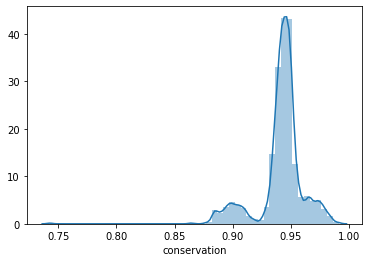

In [9]:
sns.distplot(frequencies["conservation"])

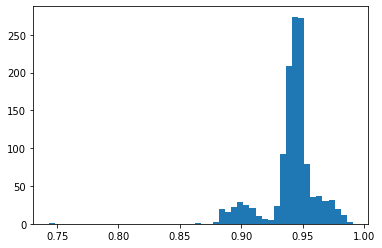

In [10]:
plt.hist(frequencies["conservation"], bins=50)
plt.savefig(join(fig_dir, "conservation_histogram.png"))
plt.savefig(join(fig_dir, "conservation_histogram.svg"))

Text(0.5, 1.0, 'Conservatin over every 20 amino acids with sliding window of 10')

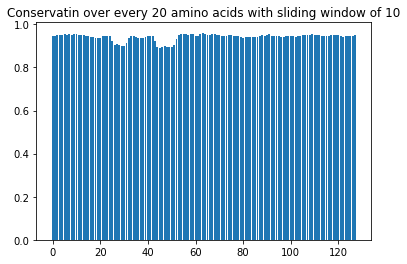

In [11]:
sliding = 10
bin_size = 20
conservation_smooth = []
for i in range(0,frequencies.shape[0], sliding):
    conservation_smooth.append(frequencies["conservation"][i:i+bin_size].mean())
    
conservation_smooth

plt.bar(range(len(conservation_smooth)), conservation_smooth)
plt.title(f"Conservatin over every {bin_size} amino acids with sliding window of {sliding}")


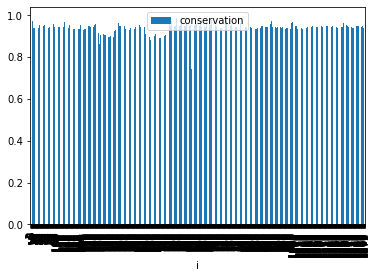

In [12]:
frequencies.plot.bar(x="i", y = "conservation")

In [13]:
(frequencies["A_i"]=="-").any()

False

### Identities file (_identities.csv)

Contains the sequence identity of each sequence in the alignment to the target sequence. 

*output key: identities_file*

columns:
- id: sequence identifier
- identity_to_query: fraction of sequence identity to the target sequence. 

In [14]:
ids = pd.read_csv(os.path.join(align_prefix + "_identities.csv"))
ids.head()

,id,identity_to_query
0,hCoV_19AnhuiSZ0052020_EPI_ISL_413485_2020_01_24,1.000
1,hCoV_19USANY_NYUMC102020_EPI_ISL_418195_2020_0...,0.000
2,hCoV_19Iceland3422020_EPI_ISL_417671_2020_03_15,0.262
3,hCoV_19pangolinGuangdong12019_EPI_ISL_410721_2019,0.096
4,hCoV_19WuhanWH022019_EPI_ISL_406799_2019_12_31,0.040


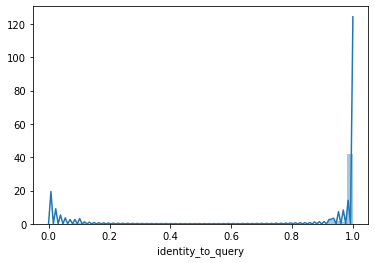

In [15]:
sns.distplot(ids["identity_to_query"])

Text(0.5, 1.0, 'Identity to query (randomly chosen representative)')

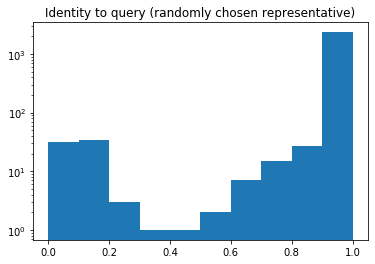

In [16]:
plt.hist(ids["identity_to_query"], log=True)
plt.title("Identity to query (randomly chosen representative)")


------

## Part 2: Coupling scores and comparison to structure

### Raw evolutionary couplings file (_ECs.txt)

### Coupling Scores File (_CouplingScores.csv)

Contains the evolutionary couplings sorted according to score, and the probability that a pair represents significant coupling rather than background noise (probability of belonging to the lognormal component of a lognormal (signal) - skew normal (noise) mixture model).

Note: this file contains couplings between positions that are close on the chain, which are known to be high due to short-range contacts in the molecule. You may want to filter these before further analysis. 

*output key: ec_file*

Columns:
- i: position i, numbered according to target sequence
- A_i: character in position i in target sequence
- Segment_i: (complexes only) specifies whether position i originates from the first monomer (A_1) or the second monomer (B_1). Position i is numbered according to its position _within_ the monomer sequence, not its overall position in the concatenated alignment. 
- j: position j, numbered according to target sequence
- A_j: character in position j in target sequence
- Segment_j: (complexes only) specifies whether position j originates from the first monomer (A_1) or the second monomer (B_1). Position j is numbered according to its position _within_ the monomer sequence, not its overall position in the concatenated alignment. 
- fn: placeholder column (formerly fn score)
- cn: Evolutionary couplings score (cn score)
- probability: Probability that this coupling is significant (i.e. in the lognormal signal tail)

In [17]:
scores = pd.read_csv(coupling_prefix +"_CouplingScores.csv")
scores.head(5)
#scores = pd.concat((scores,scores.copy().rename({"i": "j_"},axis=1).rename({"j":"i"},axis=1).rename({"j_":"j"},axis=1)),axis=0)



,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
0,998,T,1110,Y,0,0.005821,A,A,0.997168
1,322,P,373,S,0,0.005484,A,A,0.994219
2,921,K,1227,I,0,0.005287,A,A,0.991584
3,265,Y,316,S,0,0.004921,A,A,0.984334
4,190,R,366,S,0,0.004912,A,A,0.984112


### Cumulative coupling score file (_enrichment.csv)

Measures the how strongly individual residues are coupled by summing the coupling scores of pairs involving this residues, and then normalizing with the average level of coupling (i.e. enrichment of coupling on this residue relative to background). Highly enriched residues may indicate functionally important residues. Uses the top L ECs for calculation by default. 

*output key: enrichment_file*

Columns:
- i: position i
- A_i: character i
- enrichment: Sum of the evolutionary coupling scores that involve this residue, normalized by the background level of coupling

,i,A_i,enrichment
0,800,F,34.999764
1,918,E,34.930158
2,273,R,34.863627
3,1179,I,32.905996
4,867,D,31.413801
5,928,N,30.174592
6,828,L,29.463717
7,302,T,28.233173
8,362,V,26.997318
9,271,Q,25.957422


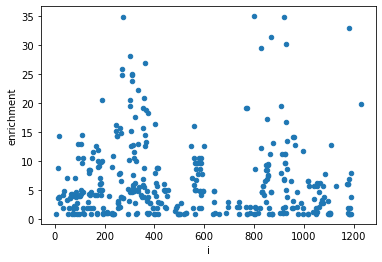

In [18]:
enrich = pd.read_csv(coupling_prefix+"_enrichment.csv")

enrich.plot.scatter(x="i",y="enrichment")
enrich.head(10)

## Take the top enriched sites and plot their amino acids

In [19]:
p_01 = scores[(scores["probability"] > 0.99)]
#sites = p_01[""]
p_01

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
0,998,T,1110,Y,0,0.005821,A,A,0.997168
1,322,P,373,S,0,0.005484,A,A,0.994219
2,921,K,1227,I,0,0.005287,A,A,0.991584


In [20]:
p_05 = scores[(scores["probability"] > 0.95)]
p_05

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
0,998,T,1110,Y,0,0.005821,A,A,0.997168
1,322,P,373,S,0,0.005484,A,A,0.994219
2,921,K,1227,I,0,0.005287,A,A,0.991584
3,265,Y,316,S,0,0.004921,A,A,0.984334
4,190,R,366,S,0,0.004912,A,A,0.984112
...,...,...,...,...,...,...,...,...,...
135,959,L,1227,I,0,0.004058,A,A,0.950858
136,302,T,362,V,0,0.004055,A,A,0.950691
137,143,V,144,Y,0,0.004048,A,A,0.950300
138,184,G,185,N,0,0.004046,A,A,0.950188


In [21]:
#scores_no_gaps = scores[~((scores["A_i"]=="-") & (scores["A_j"]=="-"))]
top_15 = scores.sort_values(["probability"], ascending=False)[:15]
top_15

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
0,998,T,1110,Y,0,0.005821,A,A,0.997168
1,322,P,373,S,0,0.005484,A,A,0.994219
2,921,K,1227,I,0,0.005287,A,A,0.991584
3,265,Y,316,S,0,0.004921,A,A,0.984334
4,190,R,366,S,0,0.004912,A,A,0.984112
5,336,C,360,N,0,0.004892,A,A,0.983609
6,273,R,336,C,0,0.004859,A,A,0.982755
7,918,E,1179,I,0,0.004807,A,A,0.981344
8,800,F,918,E,0,0.004807,A,A,0.981344
9,928,N,1179,I,0,0.004807,A,A,0.981344


## Plot the top 15 pairings

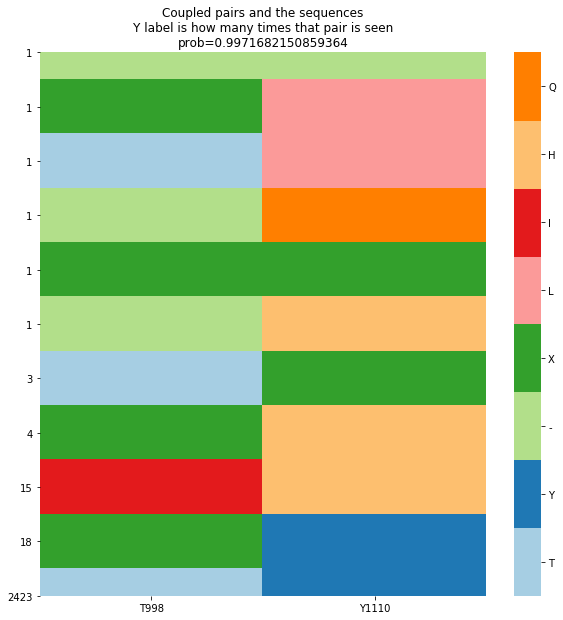

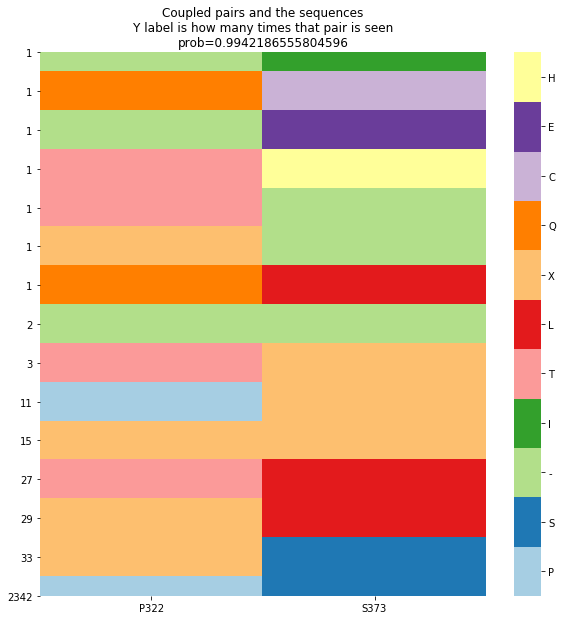

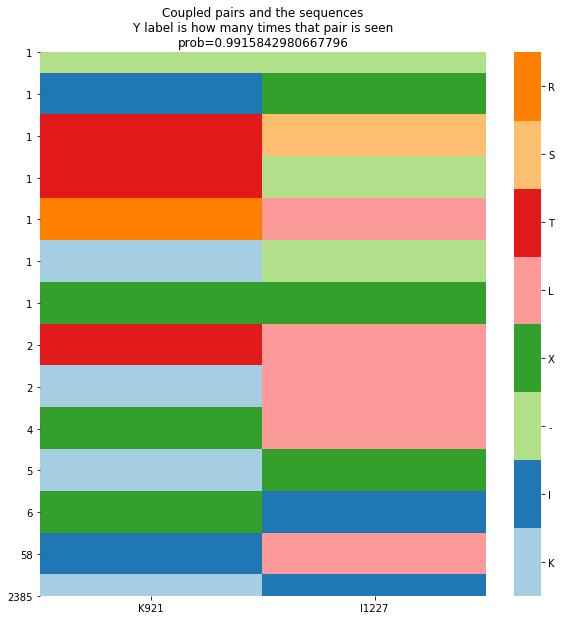

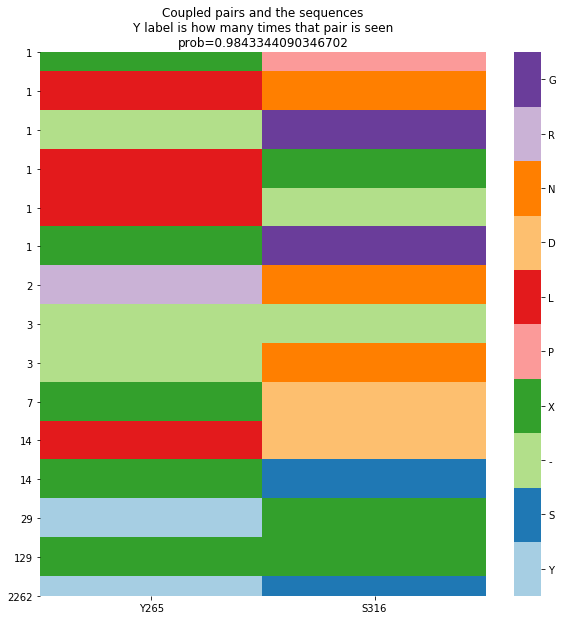

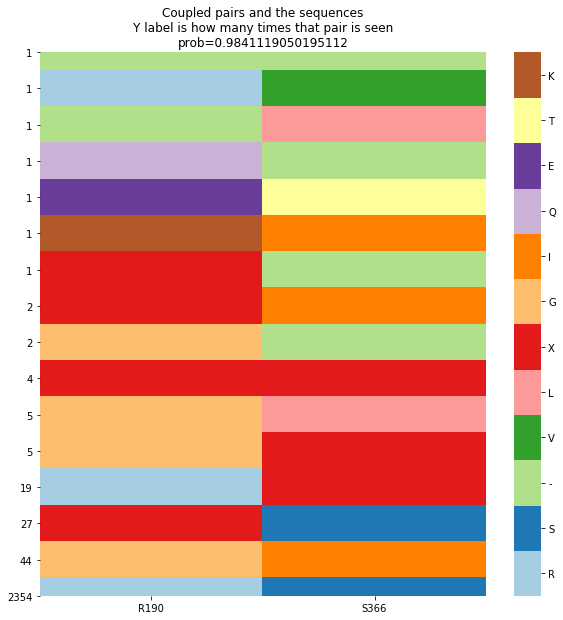

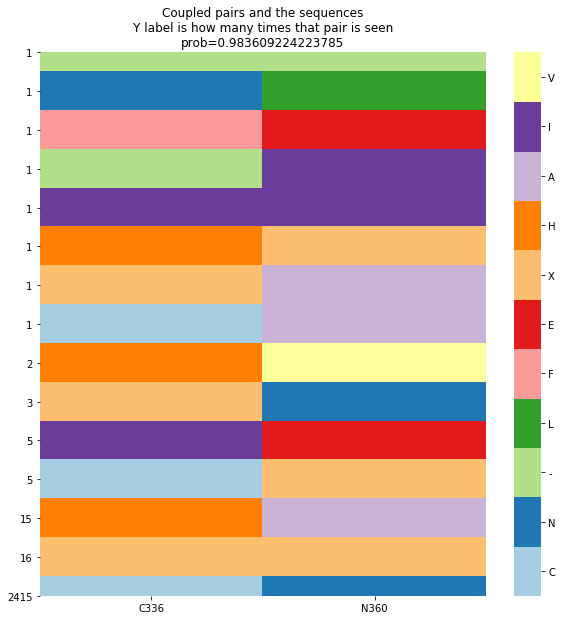

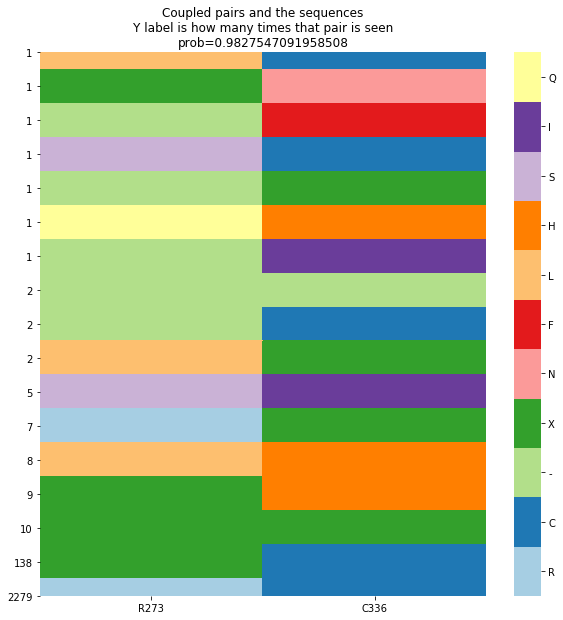

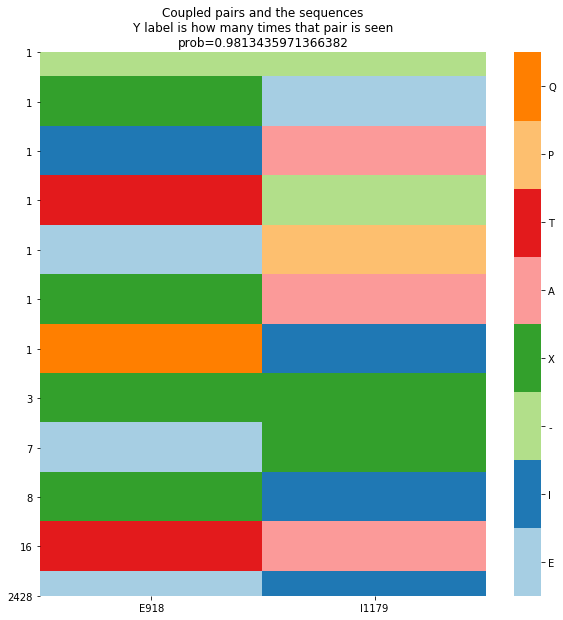

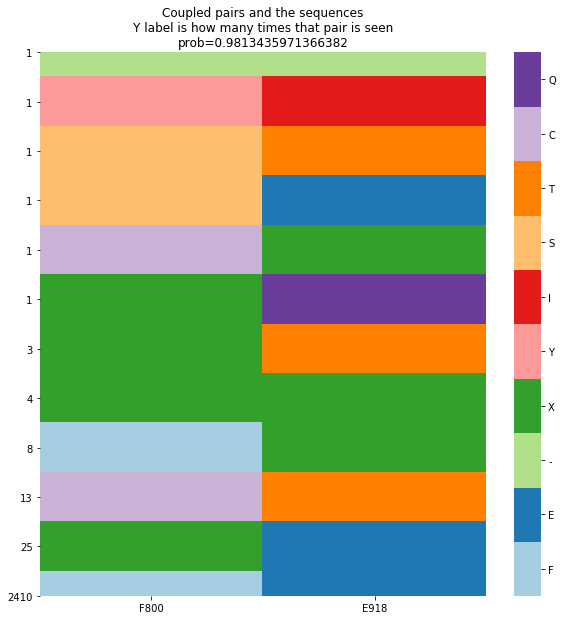

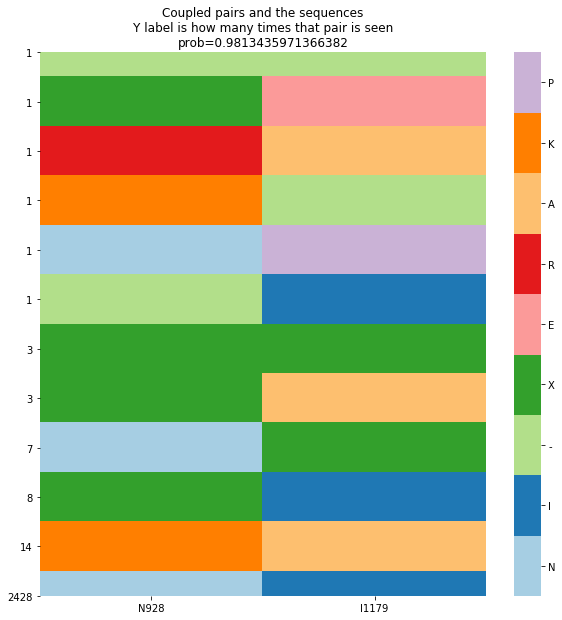

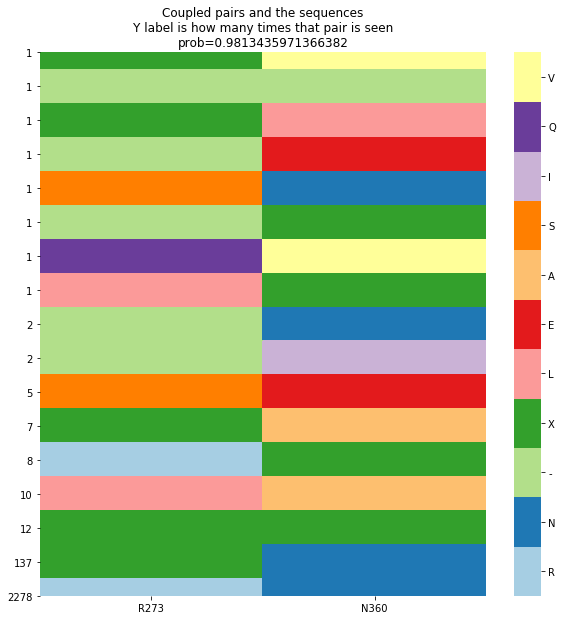

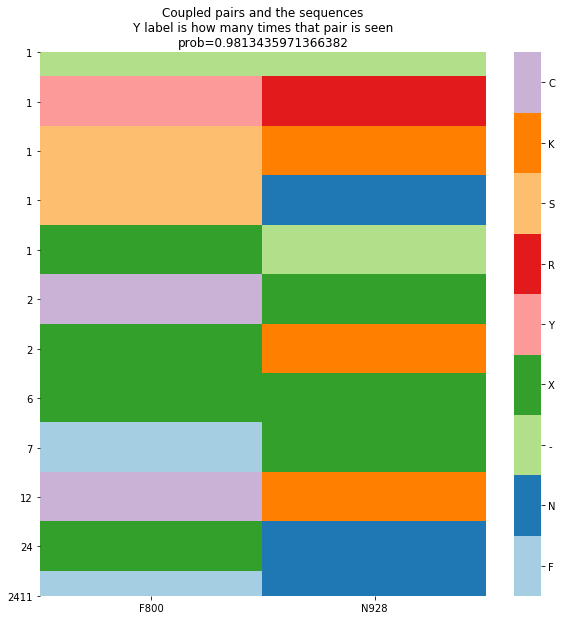

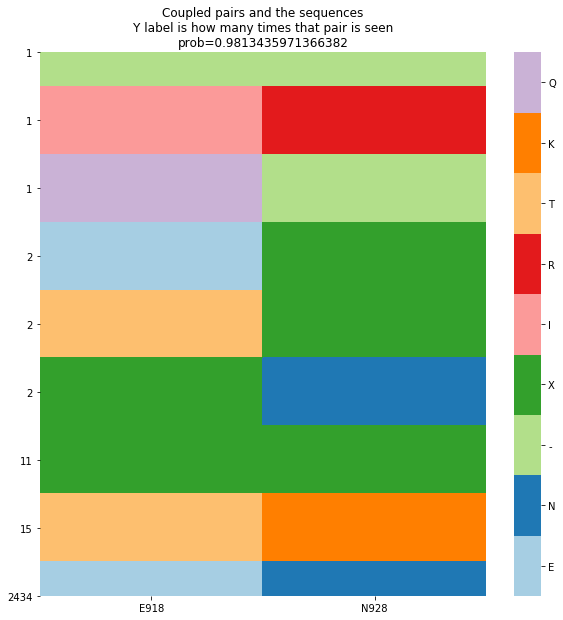

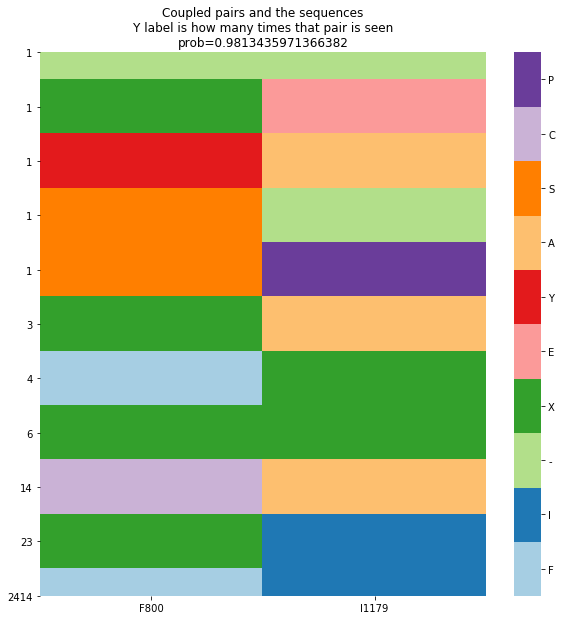

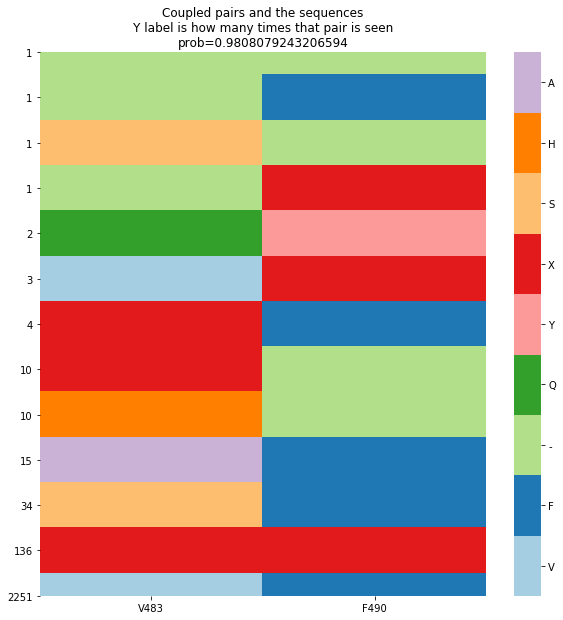

In [22]:
df = top_15

seqs_msa_a2m = read_msa(os.path.join(align_prefix+".a2m"))


#def pair_conservation_heat(df):
count = 1
for ind, val in df.iterrows():
    curr_seqs = seqs_msa_a2m[:,[val["i"]-1, val["j"]-1]]
    
    value_to_int = {j:i for i,j in enumerate(pd.unique(curr_seqs.ravel()))} # like you did
    n = len(value_to_int)
    # discrete colormap (n samples from a given cmap)
    if n > 12:
        cmap = sns.color_palette("Paired", 12) + sns.color_palette("cubehelix", n-12)
    else:
        #cmap = sns.color_palette("Pastel2", n)
        cmap = sns.color_palette("Paired", n)

    d = defaultdict(int)
    for i in curr_seqs:
        d[tuple(i)] += 1
        
    i_max = frequencies[frequencies["i"] == val["i"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].idxmax()
    j_max = frequencies[frequencies["i"] == val["j"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].idxmax()  

    curr_df = pd.DataFrame(d.keys(), index=d.values(), columns=(i_max + str(val["i"]), j_max
                                                                + str(val["j"])))
    f, ax = plt.subplots(1,1, figsize=(10,10))

    sns.heatmap(curr_df.replace(value_to_int).sort_index(), cmap=cmap,ax=ax, yticklabels=True ) 
    #plt.xticks(rotation='vertical')
    ax.tick_params(axis='y',which='major', labelrotation=0)
    # modify colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))       
    plt.title(f"Coupled pairs and the sequences\nY label is how many times that pair is seen\nprob={val['probability']}")
    plt.savefig(os.path.join(PAIR_COUPLINGS_FIGURES_DIR,'rank' + str(count) + '_' + str(val['i']) + "_" + str(val['j']))+".png")
    #plt.savefig(os.path.join(PAIR_COUPLINGS_FIGURES_DIR,str(val['i']) + "_" + str(val['j']))+".pdf")

    count += 1
#df


### To run the server for EVZoom, go to the folder (currently figures/EVzoom) and type
`python -m http.server 8000` for python3  
or `python -m SimpleHTTPServer 8000` for python2  
https://github.com/debbiemarkslab/EVzoom

then navigate to http://localhost:8000/example/covid_S.html

## GLYCOSITES
### TO DO : Need to align the original protein sequence to this one.

#### Are any of the site pairs with a glycosylation site with high coupling relative to other glycosylation sites? Relative to other sites in general?

In [23]:
glycosites = np.array([17,61,74,122,149,165,234,282,331,343,603,616,717,801,1098,1134,1194])

In [24]:
frequencies = frequencies.set_index("i",drop=False)

In [25]:
print(frequencies.loc[glycosites,"A_i"].values)
print(frequencies.loc[glycosites-1,"A_i"].values)
print(frequencies.loc[glycosites+1,"A_i"].values)
print(frequencies.loc[glycosites+2,"A_i"].values)

frequencies[frequencies["i"].isin(glycosites)]

['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
['V' 'S' 'T' 'N' 'N' 'N' 'I' 'E' 'P' 'F' 'T' 'V' 'T' 'F' 'S' 'V' 'L']
['L' 'V' 'G' 'A' 'K' 'C' 'I' 'G' 'I' 'A' 'T' 'C' 'F' 'F' 'G' 'N' 'E']
['T' 'T' 'T' 'T' 'S' 'T' 'T' 'T' 'T' 'T' 'S' 'T' 'T' 'S' 'T' 'T' 'S']


,i,A_i,conservation,-,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
i,,,,,,,,,,,,,,,,,,,,,
17,17,N,0.940,0.015,0.0,0.000,0.000,0.0,0.000,0.0,...,0.000,0.966,0.000,0.000,0.0,0.000,0.014,0.004,0.000,0.000
61,61,N,0.950,0.024,0.0,0.000,0.000,0.0,0.000,0.0,...,0.000,0.970,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
74,74,N,0.946,0.007,0.0,0.000,0.000,0.0,0.000,0.0,...,0.000,0.970,0.000,0.000,0.0,0.000,0.000,0.000,0.017,0.000
122,122,N,0.951,0.024,0.0,0.000,0.000,0.0,0.000,0.0,...,0.000,0.970,0.000,0.000,0.0,0.000,0.005,0.000,0.000,0.000
149,149,N,0.942,0.007,0.0,0.016,0.000,0.0,0.000,0.0,...,0.000,0.969,0.000,0.000,0.0,0.000,0.006,0.000,0.000,0.000
165,165,N,0.934,0.009,0.0,0.001,0.000,0.0,0.000,0.0,...,0.000,0.965,0.002,0.000,0.0,0.015,0.000,0.000,0.000,0.000
234,234,N,0.939,0.021,0.0,0.000,0.002,0.0,0.002,0.0,...,0.000,0.966,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.007
282,282,N,0.911,0.070,0.0,0.000,0.000,0.0,0.000,0.0,...,0.000,0.928,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
331,331,N,0.934,0.009,0.0,0.000,0.000,0.0,0.015,0.0,...,0.001,0.965,0.000,0.000,0.0,0.002,0.007,0.000,0.000,0.000


In [26]:
#scores[(scores["i"].isin(glycosites)) | (scores["j"].isin(glycosites))]

## Plot the glycosites coupling across positions

Position 17
Position 61
Position 74
Position 122
Position 149
Position 165
Position 234
Position 282
Position 331
Position 343
Position 603
Position 616
Position 717
Position 801
Position 1098
Position 1134
Position 1194


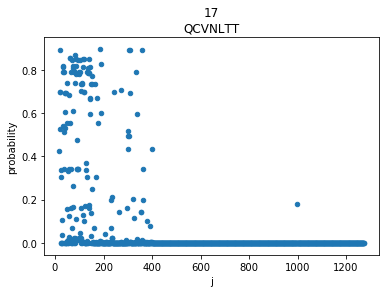

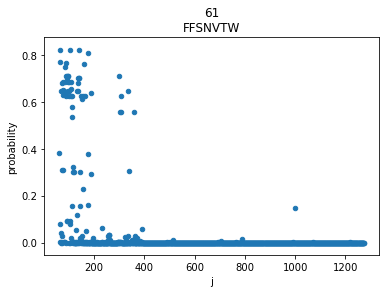

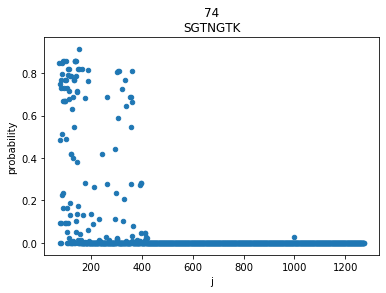

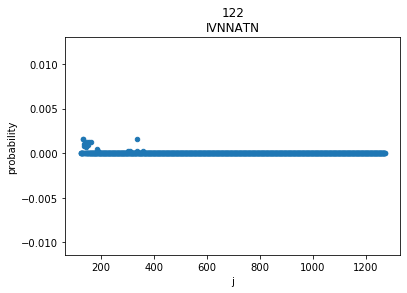

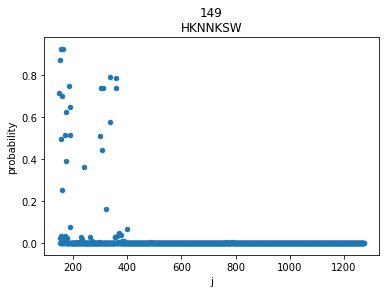

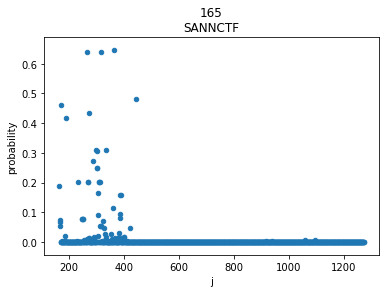

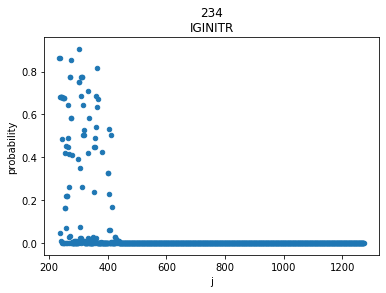

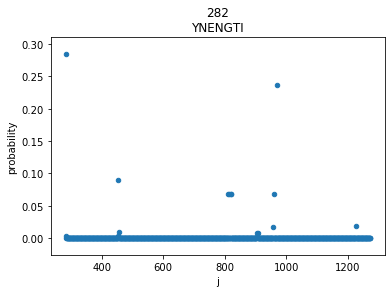

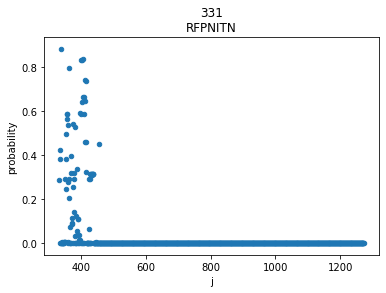

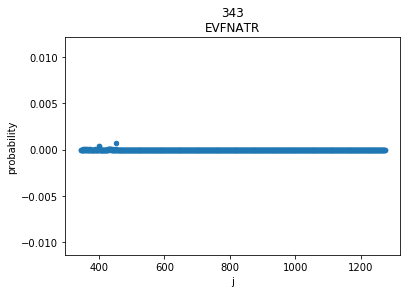

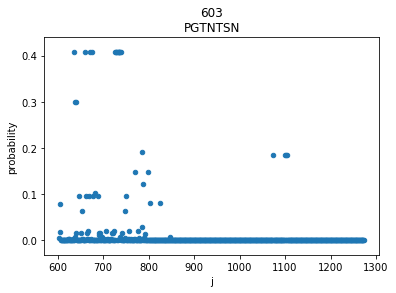

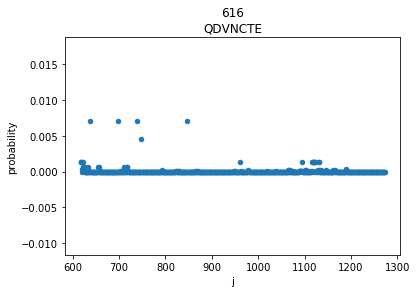

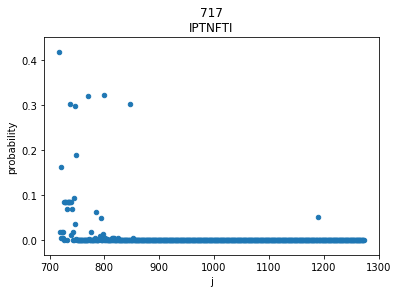

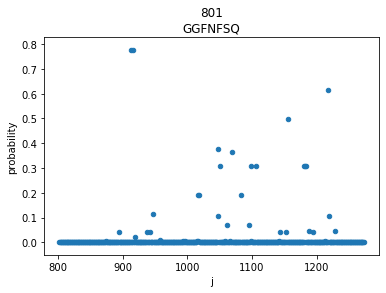

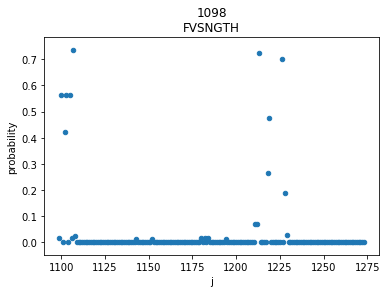

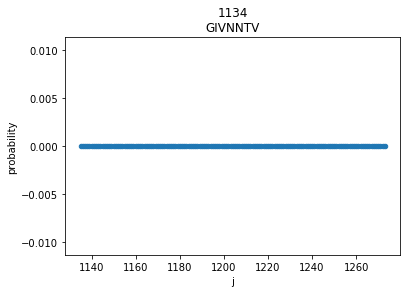

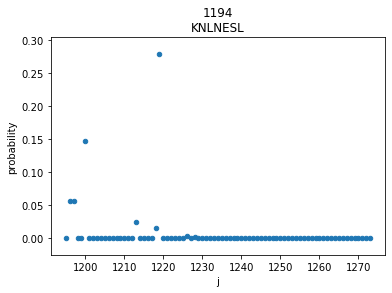

In [27]:
for ind,val in scores[scores["i"].isin(glycosites)].groupby("i"):
    print("Position", val["i"].values[0])
    val.plot.scatter("j","probability")
    title = "".join(conserved_sequence[int(ind)-1-3 : int(ind)-1+4])
    plt.title(str(ind) + "\n" + title)

## Add in adjacent sites (+/- 3 aa)

In [28]:
adj_sites = []
for i in glycosites:
    adj_sites += list(range(i-3, i+3))
adj_sites = set(adj_sites)


In [29]:
print("Number of contacts with probability greater than 0.9 when both residues are adj_sites: ", (scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites))]["probability"]>0.9).sum())
print("Number of contacts with probability greater than 0.9 when either residues is a adj_sites: ",(scores[(scores["i"].isin(adj_sites)) | (scores["j"].isin(adj_sites))]["probability"]>0.9).sum())


Number of contacts with probability greater than 0.9 when both residues are adj_sites:  3
Number of contacts with probability greater than 0.9 when either residues is a adj_sites:  91


In [30]:
print("Number of contacts with probability greater than 0.7 when both residues are adj_sites: ", (scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites))]["probability"]>0.7).sum())
print("Number of contacts with probability greater than 0.7 when either residues is a adj_sites: ",(scores[(scores["i"].isin(adj_sites)) | (scores["j"].isin(adj_sites))]["probability"]>0.7).sum())


Number of contacts with probability greater than 0.7 when both residues are adj_sites:  98
Number of contacts with probability greater than 0.7 when either residues is a adj_sites:  1286


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


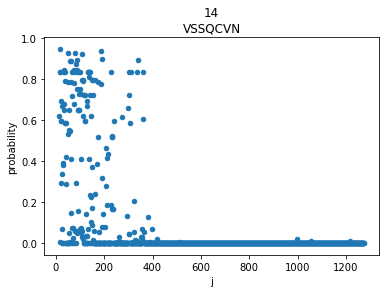

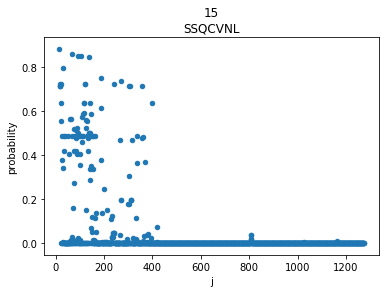

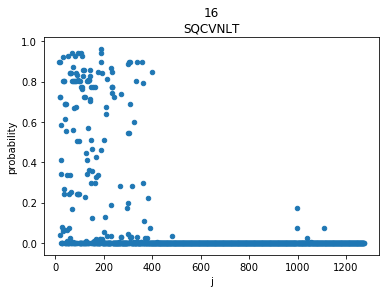

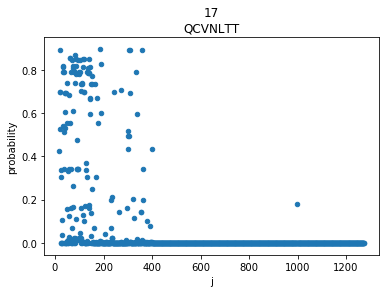

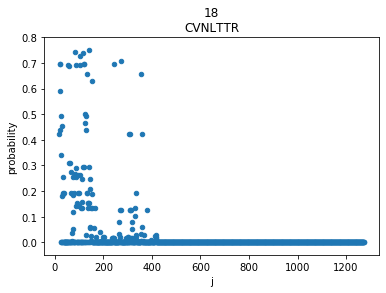

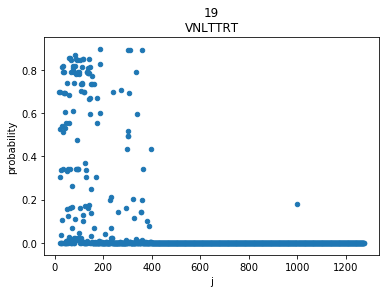

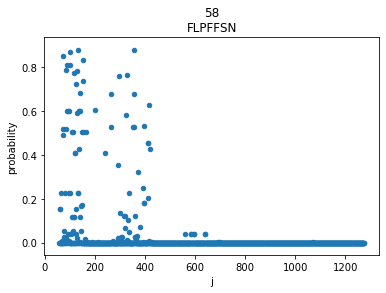

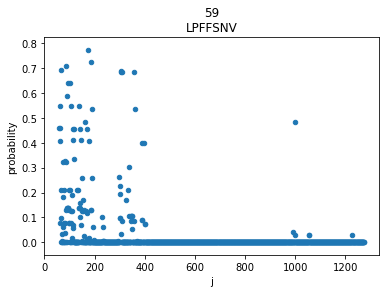

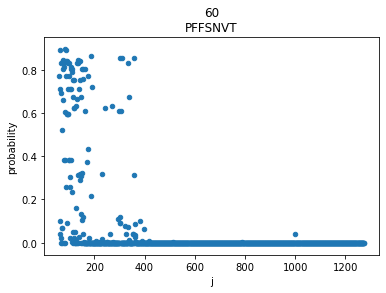

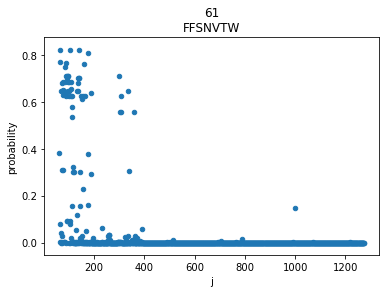

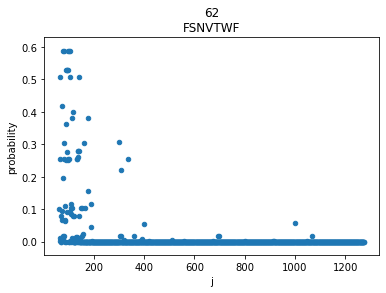

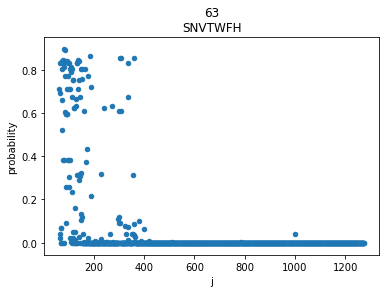

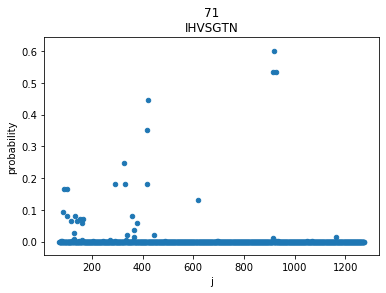

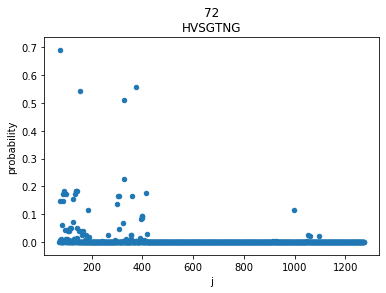

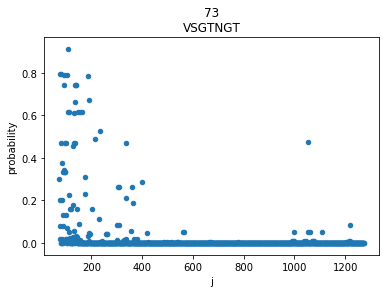

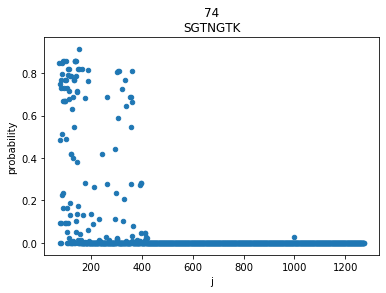

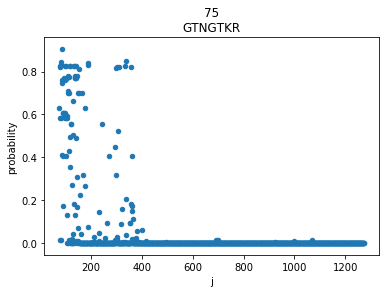

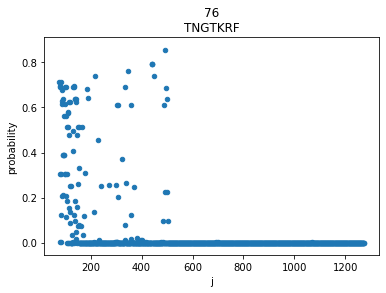

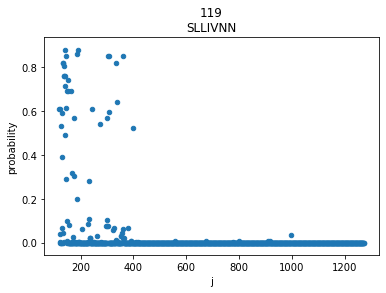

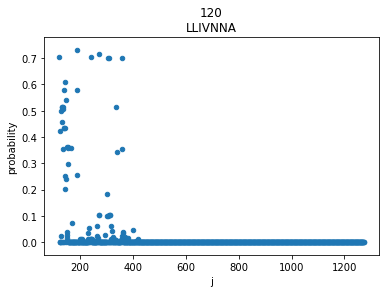

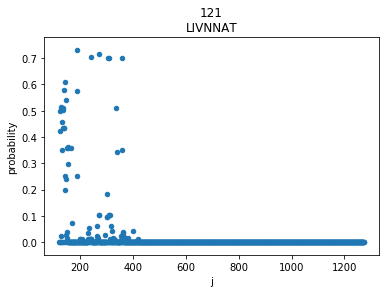

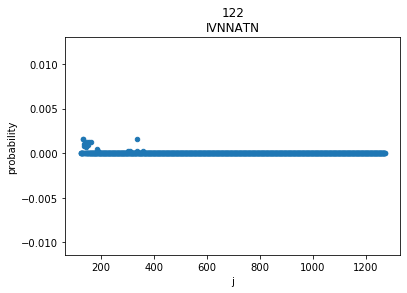

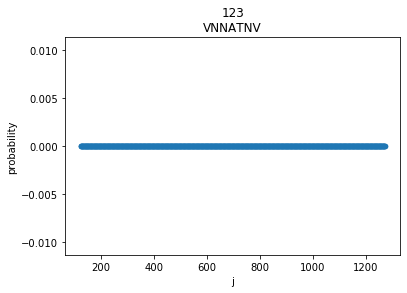

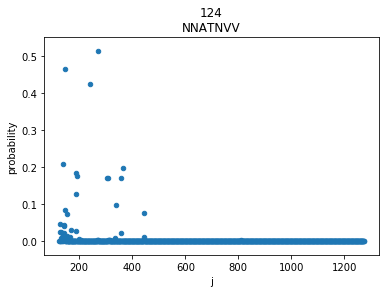

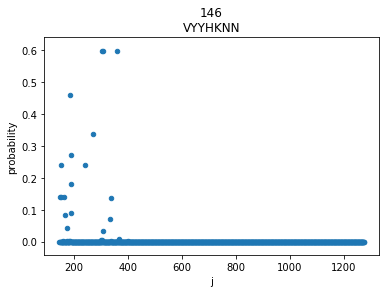

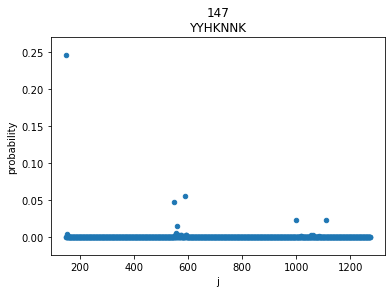

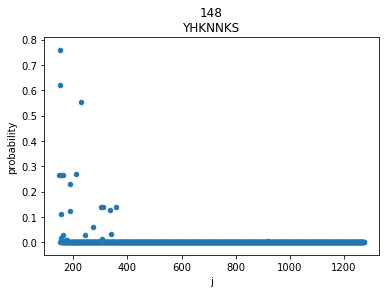

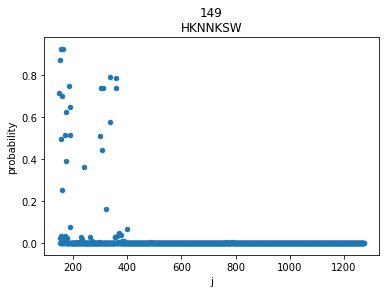

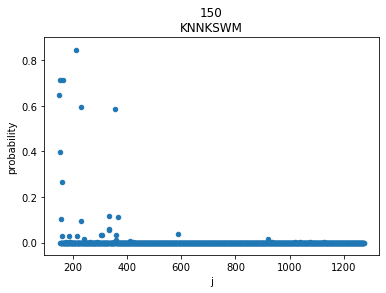

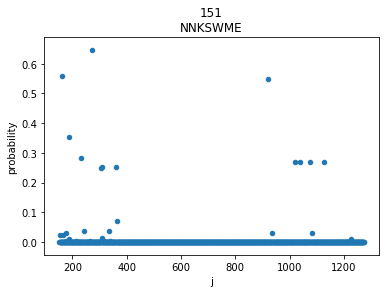

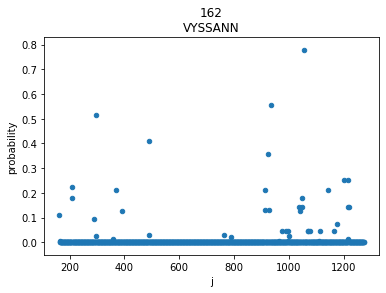

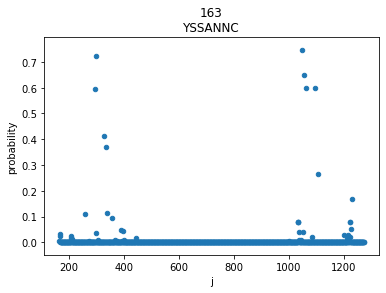

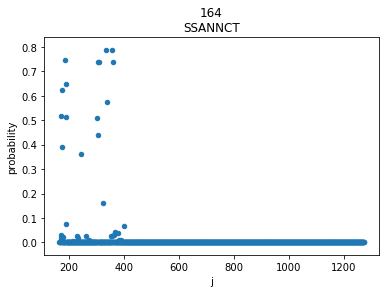

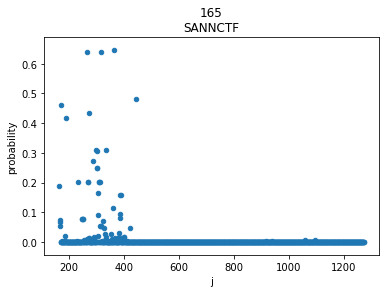

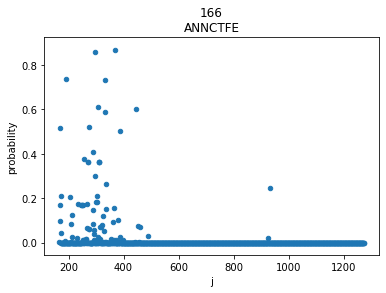

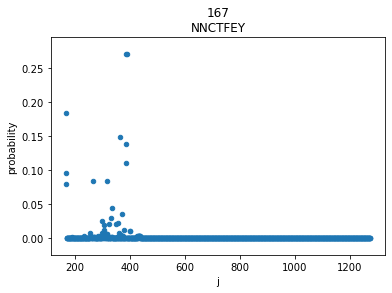

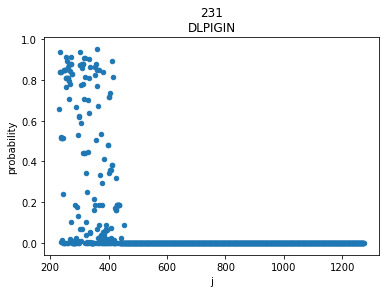

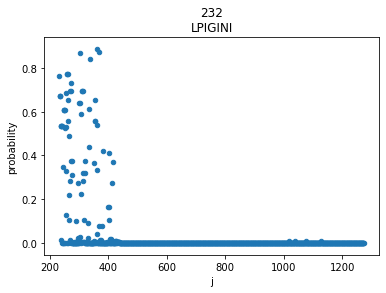

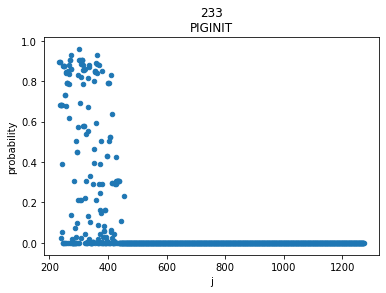

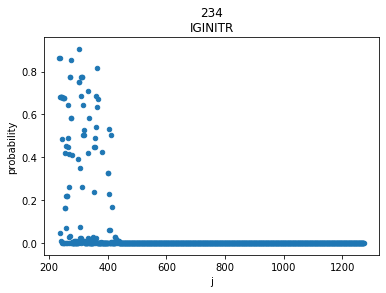

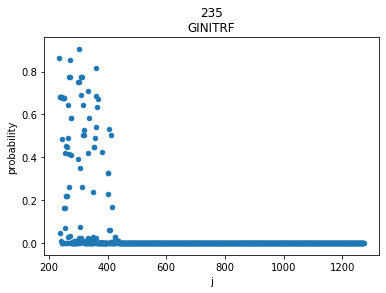

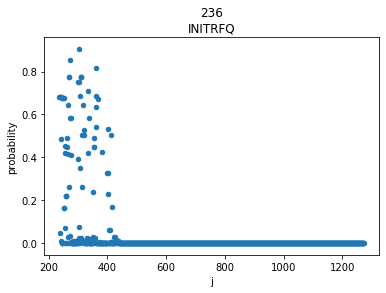

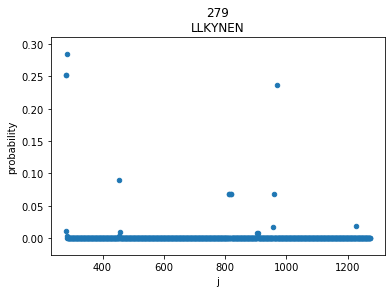

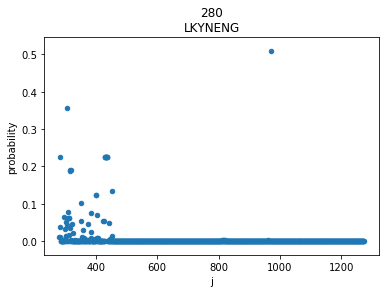

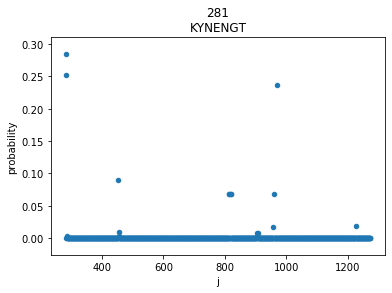

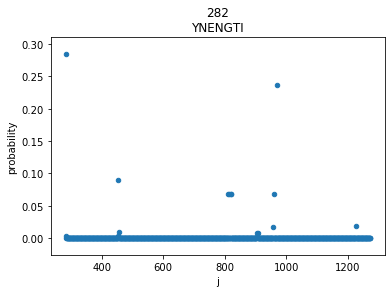

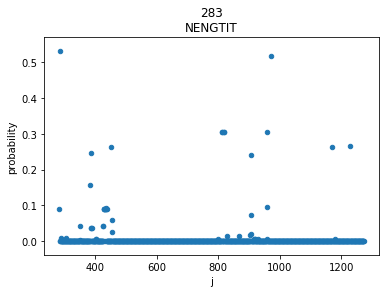

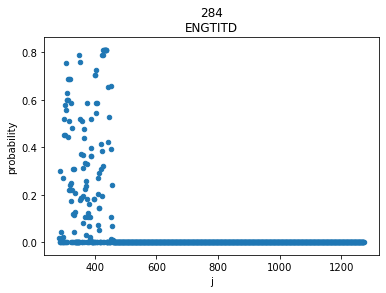

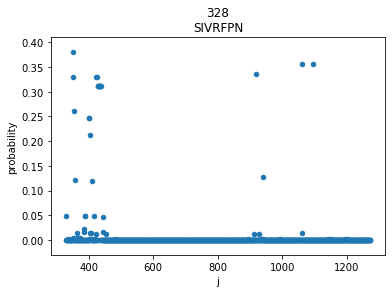

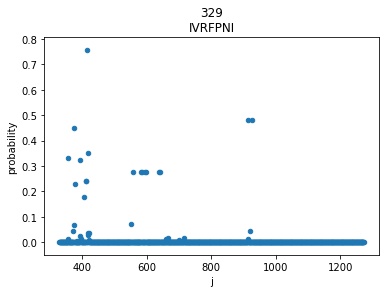

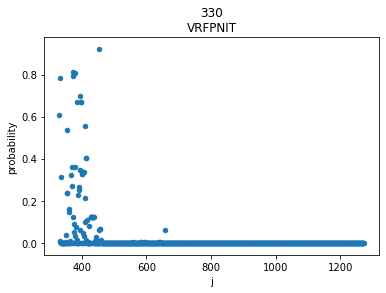

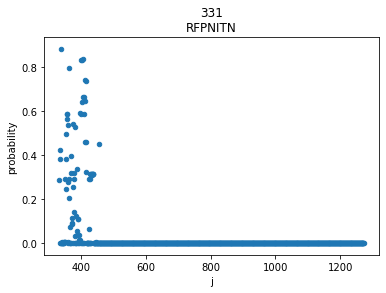

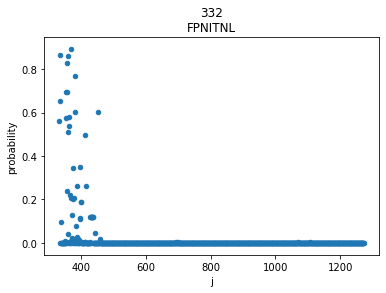

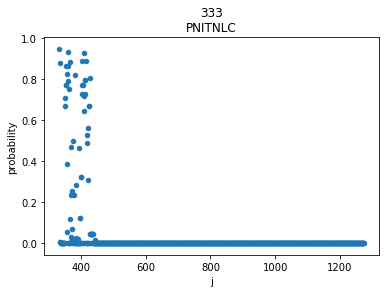

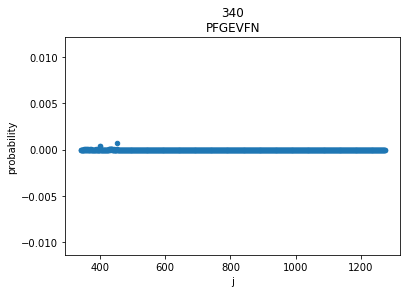

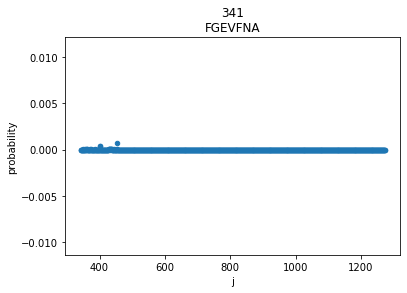

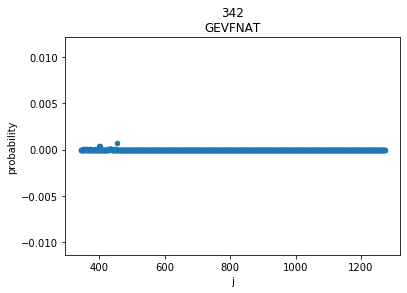

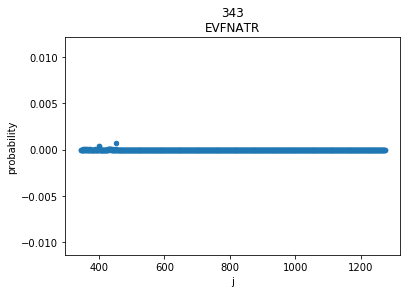

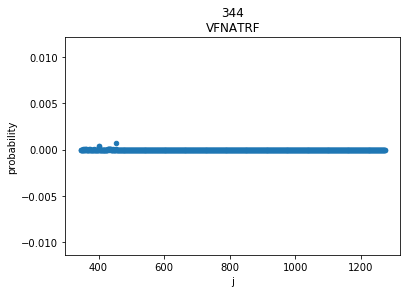

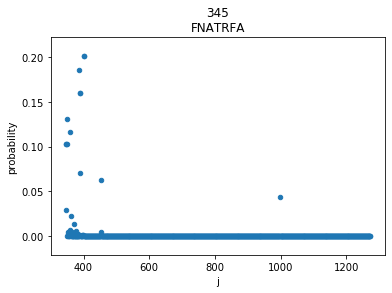

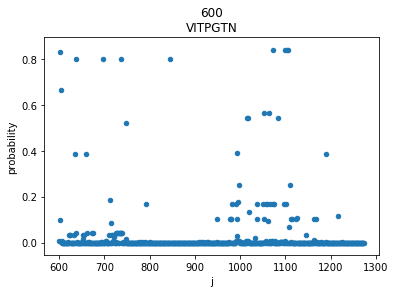

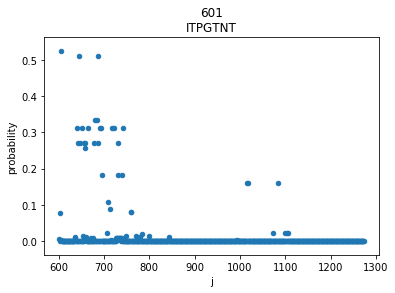

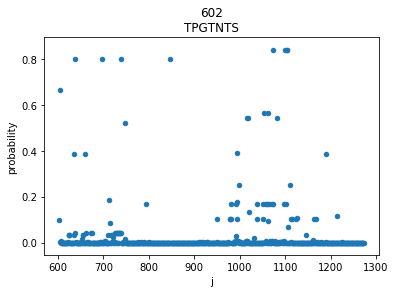

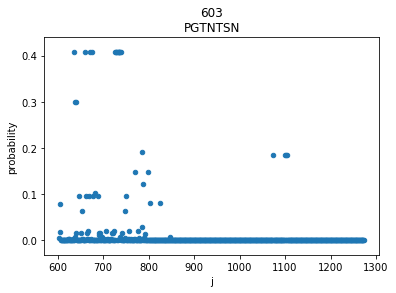

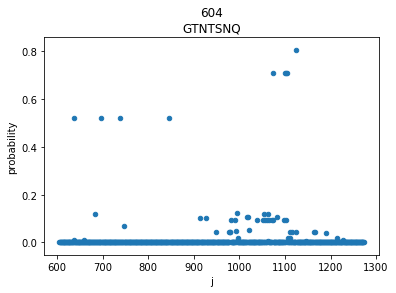

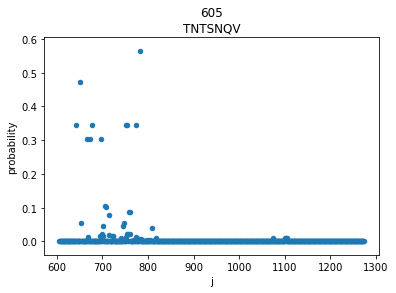

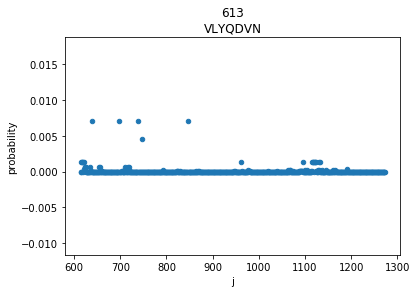

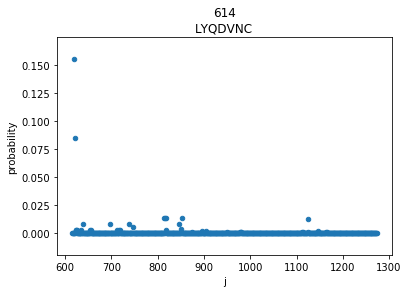

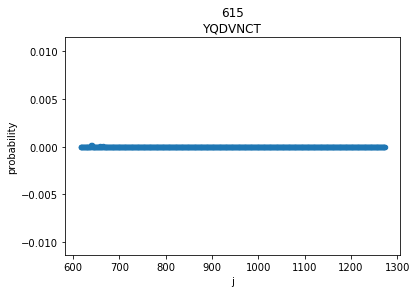

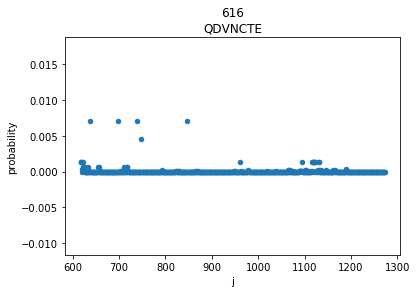

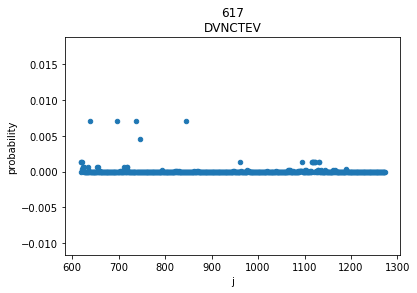

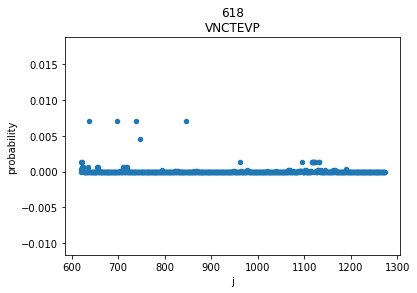

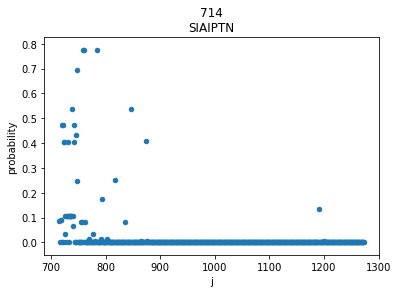

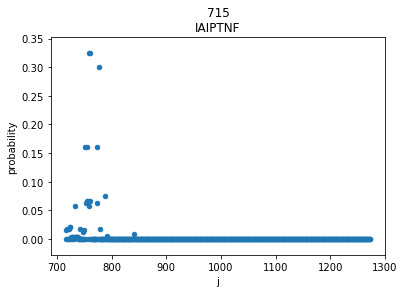

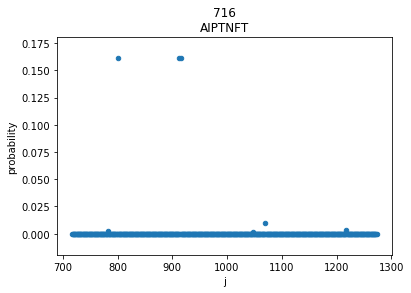

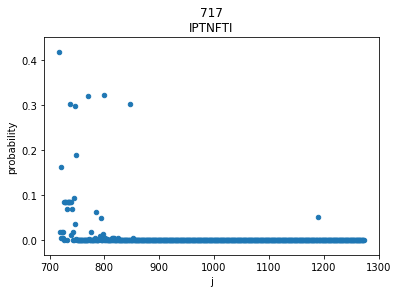

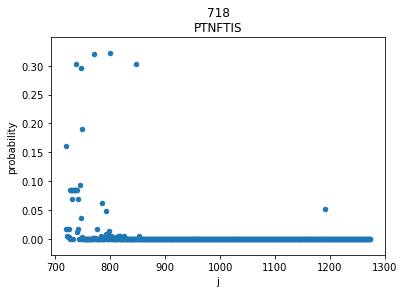

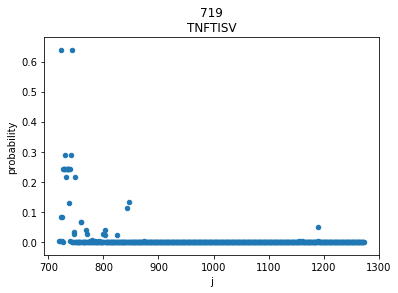

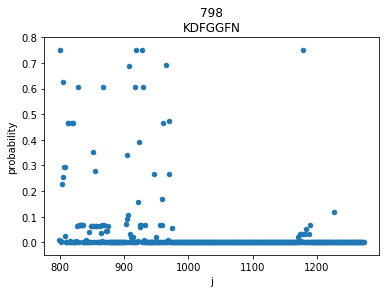

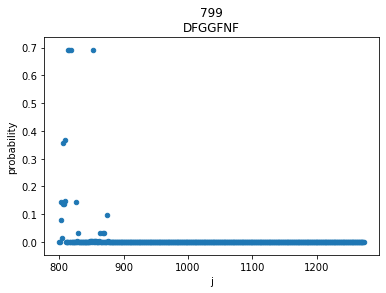

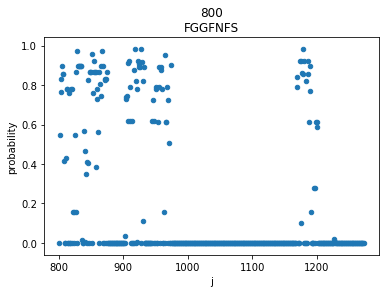

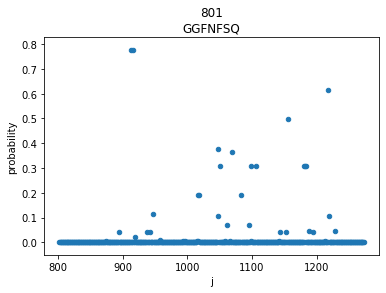

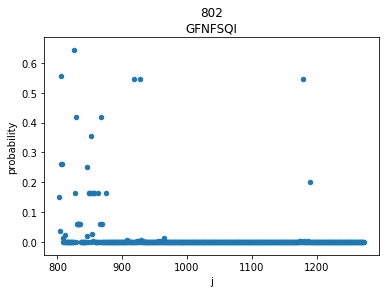

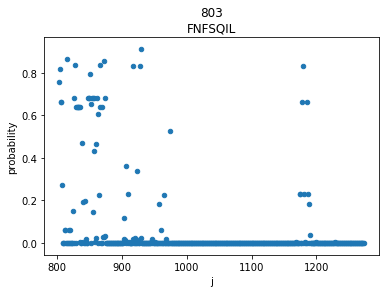

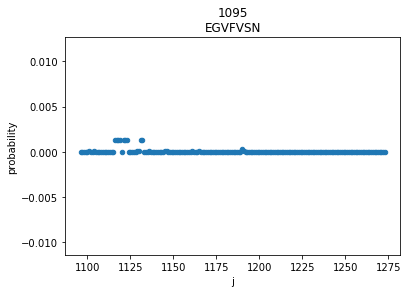

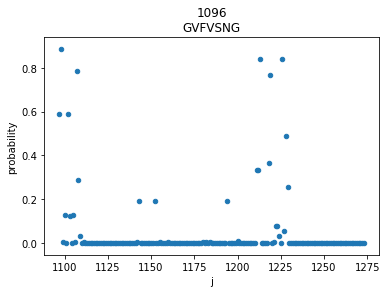

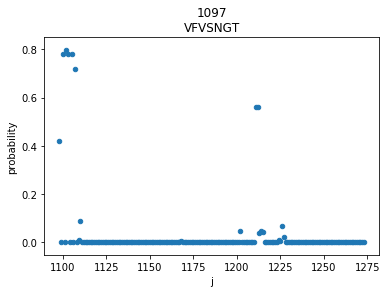

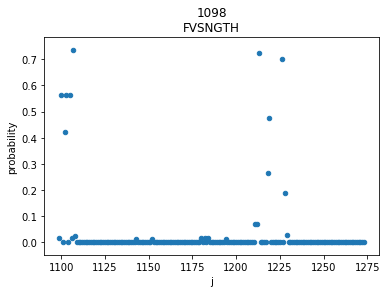

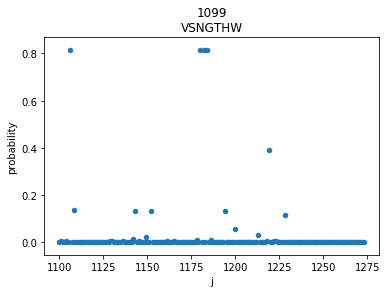

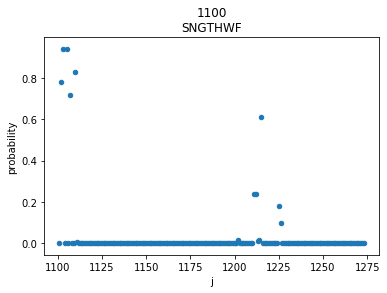

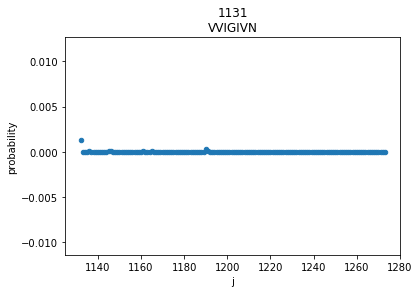

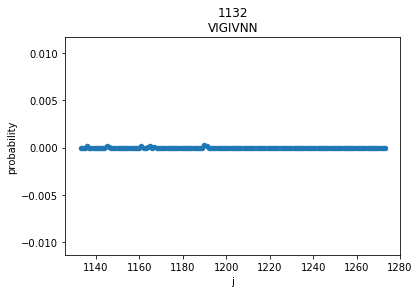

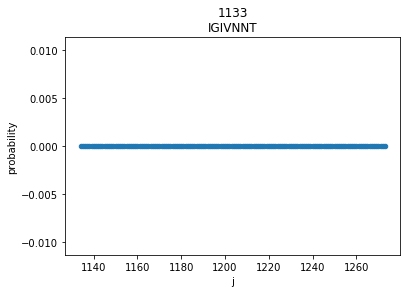

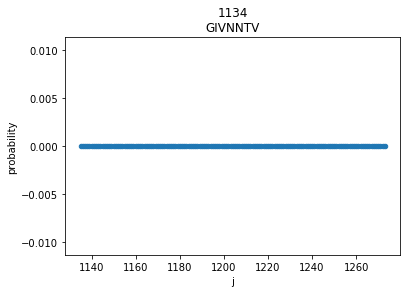

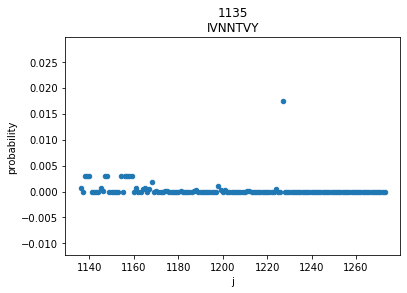

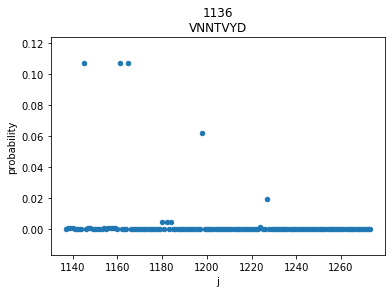

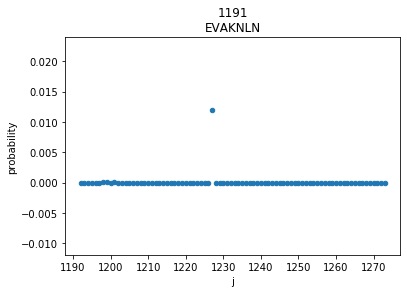

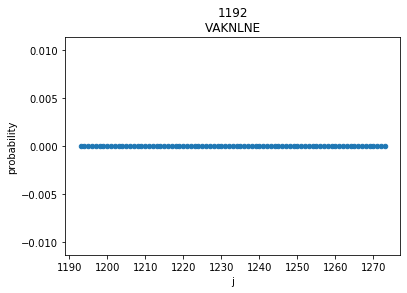

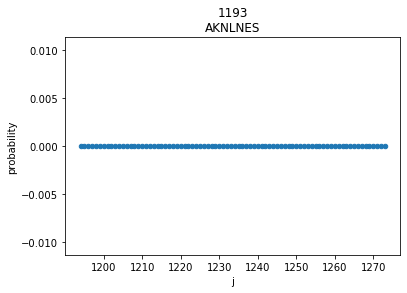

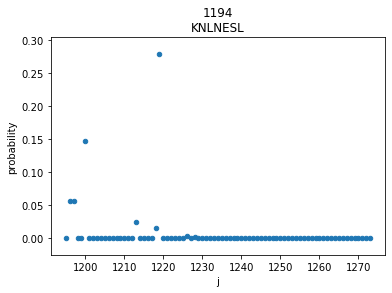

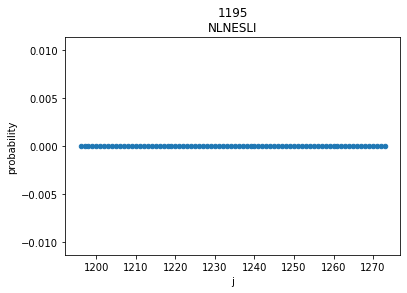

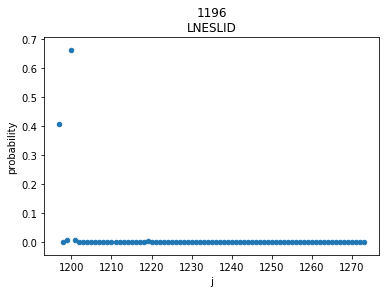

In [31]:
for ind,val in scores[scores["i"].isin(adj_sites)].groupby("i"):
    #print("Position", val["i"].values[0])
    val.plot.scatter("j","probability")
    title = "".join(conserved_sequence[int(ind)-1-3 : int(ind)-1+4])
    plt.title(str(ind) + "\n" + title)
    plt.savefig(join(GLYCO_PAIR_COUPLINGS_FIGURES_DIR, "couple_probability_position_" + str(ind)+".png" ))

In [32]:
seqs_msa_a2m = read_msa(join(align_prefix+".a2m"))
glyco_seqs_msa_a2m = seqs_msa_a2m[:,glycosites-1]
adj_seqs_msa_a2m = seqs_msa_a2m[:,np.array(list(adj_sites))-1] 

In [33]:
scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites)) & (scores["probability"]>0.9)]

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
175,14,Q,16,V,0,0.003950,A,A,0.944565
251,231,I,233,I,0,0.003821,A,A,0.936210
418,149,N,164,N,0,0.003633,A,A,0.922039


,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
175,14,Q,16,V,0,0.003950,A,A,0.944565
251,231,I,233,I,0,0.003821,A,A,0.936210
418,149,N,164,N,0,0.003633,A,A,0.922039
1257,17,N,19,T,0,0.003356,A,A,0.895071
1258,16,V,17,N,0,0.003356,A,A,0.895071


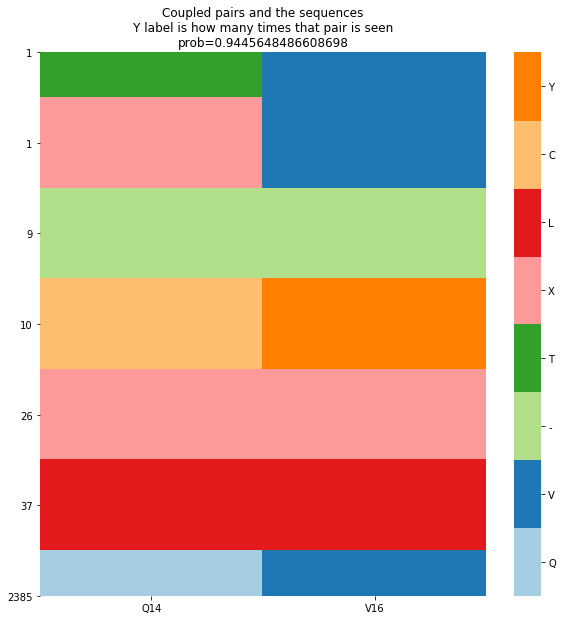

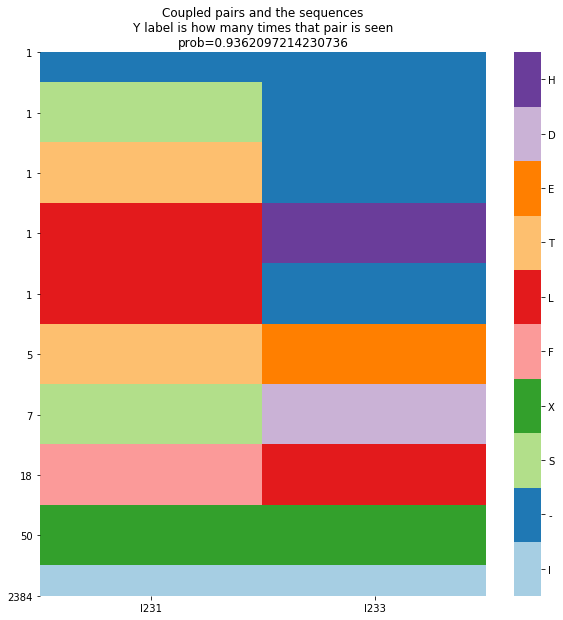

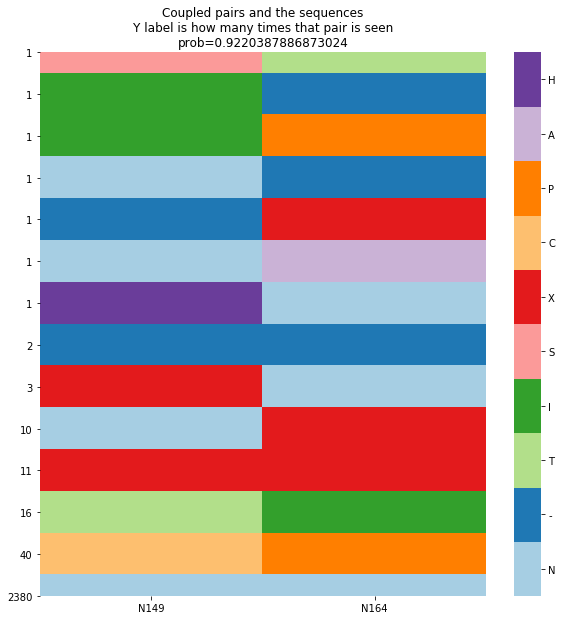

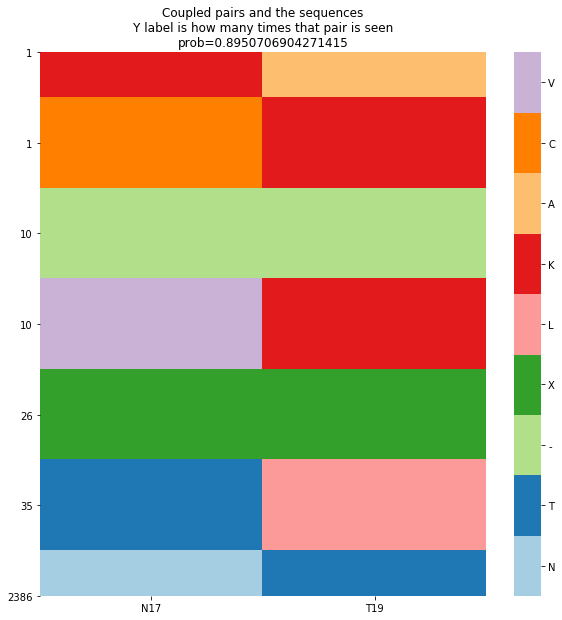

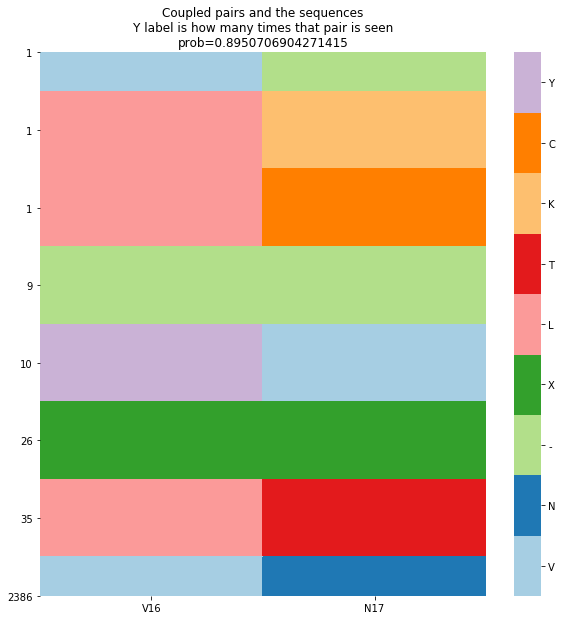

In [34]:
df = scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites))][:5] #&(scores["probability"]>0.95)]
#df = p_05

seqs_msa_a2m = read_msa(os.path.join(align_prefix+".a2m"))


#def pair_conservation_heat(df):
count = 1
for ind, val in df.iterrows():
    curr_seqs = seqs_msa_a2m[:,[val["i"]-1, val["j"]-1]]
    
    value_to_int = {j:i for i,j in enumerate(pd.unique(curr_seqs.ravel()))} # like you did
    n = len(value_to_int)
    # discrete colormap (n samples from a given cmap)
    if n > 12:
        cmap = sns.color_palette("Paired", 12) + sns.color_palette("cubehelix", n-12)
    else:
        #cmap = sns.color_palette("Pastel2", n)
        cmap = sns.color_palette("Paired", n)

    d = defaultdict(int)
    for i in curr_seqs:
        d[tuple(i)] += 1
        
    i_max = frequencies[frequencies["i"] == val["i"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].idxmax()
    j_max = frequencies[frequencies["i"] == val["j"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].idxmax()  

    curr_df = pd.DataFrame(d.keys(), index=d.values(), columns=(i_max + str(val["i"]), j_max
                                                                + str(val["j"])))

    f, ax = plt.subplots(1,1, figsize=(10,10))

    sns.heatmap(curr_df.replace(value_to_int).sort_index(), cmap=cmap,ax=ax, yticklabels=True ) 
    #plt.xticks(rotation='vertical')
    ax.tick_params(axis='y',which='major', labelrotation=0)
    # modify colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))       
    plt.title(f"Coupled pairs and the sequences\nY label is how many times that pair is seen\nprob={val['probability']}")
    plt.savefig(os.path.join(GLYCO_PAIR_COUPLINGS_FIGURES_DIR,'rank' + str(count) + '_' + str(val['i']) + "_" + str(val['j']))+".png")
    #plt.savefig(os.path.join(GLYCO_PAIR_COUPLINGS_FIGURES_DIR,str(val['i']) + "_" + str(val['j']))+".pdf")
    #break
    count += 1
df


In [35]:
GLYCO_PAIR_COUPLINGS_FIGURES_DIR

'/data2/isshamie/covid/covid_03302020/figures/glycosites_pair_couplings'

{'Q': 0, 'C': 1, 'V': 2, 'N': 3, 'L': 4, 'T': 5, 'F': 6, 'S': 7, 'G': 8, 'P': 9, 'D': 10, 'I': 11, 'A': 12, 'H': 13, 'K': 14, 'E': 15, 'Y': 16, 'R': 17, '-': 18, 'X': 19, 'W': 20, 'M': 21}


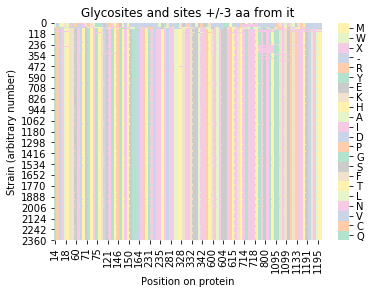

<Figure size 432x288 with 0 Axes>

In [36]:
value_to_int = {j:i for i,j in enumerate(pd.unique(adj_seqs_msa_a2m.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 
ax = sns.heatmap(pd.DataFrame(adj_seqs_msa_a2m, 
                              columns=frequencies[frequencies["i"].isin(adj_sites)]["i"].values).replace(value_to_int), cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
print(value_to_int)
colorbar.set_ticklabels(list(value_to_int.keys()))       
plt.title("Glycosites and sites +/-3 aa from it")
plt.xlabel("Position on protein")
#ax.set_yticks([])
plt.ylabel("Strain (arbitrary number)")
plt.show()
plt.savefig(join(GLYCO_PAIR_COUPLINGS_FIGURES_DIR, "glycosites_with_adjacent_sites.png"))

{'N': 0, '-': 1, 'T': 2, 'I': 3, 'X': 4, 'R': 5, 'K': 6, 'L': 7, 'F': 8, 'W': 9, 'S': 10, 'C': 11, 'D': 12, 'V': 13, 'Y': 14, 'P': 15, 'Q': 16, 'M': 17, 'E': 18, 'H': 19, 'A': 20}


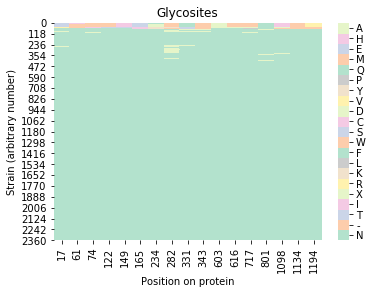

<Figure size 432x288 with 0 Axes>

In [37]:
value_to_int = {j:i for i,j in enumerate(pd.unique(glyco_seqs_msa_a2m.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 
ax = sns.heatmap(pd.DataFrame(glyco_seqs_msa_a2m, 
                              columns=frequencies[frequencies["i"].isin(glycosites)]["i"].values).replace(value_to_int), cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
print(value_to_int)
colorbar.set_ticklabels(list(value_to_int.keys()))                                          
plt.title("Glycosites")
plt.xlabel("Position on protein")
#ax.set_yticks([])
plt.ylabel("Strain (arbitrary number)")
plt.show()
plt.savefig(join(GLYCO_PAIR_COUPLINGS_FIGURES_DIR, "all_glycosites.png"))